In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data import dataloader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import datetime

In [3]:
pilot_data, notes = dataloader.load_from_firebase(notes=True,
                                                  start=datetime.datetime(2018, 3, 6, 8),
                                                  combine=True,
                                                  marked=True)

Data loaded from Firebase!


In [15]:
pilot_data[pilot_data.ontarget==True][pilot_data.thermopile1!=False][['coordinator', 'secondCoordinator']].drop_duplicates()

,coordinator,secondCoordinator
2,Jake Son,Jon Clucas
1077,Jake Son,NaN
5719,Jon Clucas,Arno Klein
7198,Jon Clucas,Anirudh Krishnakumar
11030,Jon Clucas,Jake Son
16049,Jake Son,Anirudh Krishnakumar


In [16]:
pilot_data = pilot_data[pilot_data.ontarget==True][pilot_data.thermopile1!=False]

In [18]:
pilot_data = pilot_data[['coordinator', 'secondCoordinator', 'target', 'step', 'distance', 'thermopile1', 'thermopile2', 'thermopile3', 'thermopile4']]

In [37]:
item_1 = ['Jake Son', 'Jon Clucas']
item_2 = ['Jon Clucas', 'Arno Klein']

for c1, c2 in [item_1, item_2]:

    print('Coordinators: ' + str(c1) + , c2))
    print(pilot_data[(pilot_data.coordinator==c1) & (pilot_data.secondCoordinator==c2)][-1:])


TypeError: decoding str is not supported

In [5]:
for target in list(pilot_data.target.unique()):
    ib =max(
        pilot_data.loc[
            pilot_data.target==target
        ].step.dropna()
    )
    print(": ".join([
        target,
        "{0} on-target samples in {1} iteration block{2}".format(
            str(len(pilot_data.loc[
                (pilot_data.target == target) &
                (pilot_data.ontarget)
            ])),
            "%.0f" % ib,
            "s" if ib != 1 else ""
        )
    ]))

offbody-spiral: 450 on-target samples in 47 iteration blocks
food: 228 on-target samples in 3 iteration blocks
thumb: 265 on-target samples in 6 iteration blocks
nails: 276 on-target samples in 9 iteration blocks
smoke: 327 on-target samples in 12 iteration blocks
rotate-mouth: 1212 on-target samples in 13 iteration blocks
nose: 292 on-target samples in 16 iteration blocks
rotate-nose: 1213 on-target samples in 17 iteration blocks
cheek: 264 on-target samples in 20 iteration blocks
rotate-cheek: 1207 on-target samples in 21 iteration blocks
eyebrow: 261 on-target samples in 24 iteration blocks
rotate-eyebrow: 1220 on-target samples in 25 iteration blocks
top-head: 493 on-target samples in 28 iteration blocks
rotate-top-head: 1374 on-target samples in 29 iteration blocks
back-head: 289 on-target samples in 32 iteration blocks
rotate-back-head: 1208 on-target samples in 33 iteration blocks
rotate-chin: 1216 on-target samples in 34 iteration blocks
rotate-above-ear: 1212 on-target samples

In [164]:
# Group each on_target with off_target regions for training/testing

target_groupings = {'food': ['nose', 'cheek', 'eyebrow', 'top-head'],
                    'thumb': ['nose', 'cheek', 'eyebrow', 'top-head'],
                    'nails': ['nose', 'cheek', 'eyebrow', 'top-head'],
                    'smoke': ['paint-front-neck', 'nose', 'cheek', 'eyebrow', 'top-head'],
                    'nose': ['paint-front-neck', 'chin', 'food', 'thumb', 'nails', 'smoke', 'cheek', 'eyebrow', 'top-head'],
                    'cheek': ['paint-front-neck', 'chin', 'food', 'thumb', 'nails', 'smoke', 'nose', 'eyebrow', 'top-head'],
                    'eyebrow': ['paint-front-neck', 'chin', 'food', 'thumb', 'nails', 'smoke', 'nose', 'cheek', 'top-head'],
                    'top-head': ['paint-front-neck', 'chin', 'food', 'thumb', 'nails', 'smoke', 'nose', 'cheek', 'eyebrow']
                   }

In [165]:
# Separate data into on-target and off-target data

def parse_data(on_target, target_groupings):
    
    targets = ['food', 'thumb', 'nails', 'smoke', 'nose', 'cheek', 'eyebrow', 'top-head']
    off_targets = ['behind-ear', 'forehead', 'back-head', 'opposite-face', 'rotate-mouth',
                   'rotate-nose', 'rotate-cheek', 'rotate-eyebrow', 'rotate-top-head', 'rotate-back-head',
                   'rotate-chin', 'rotate-above-ear', 'rotate-opposite-cheek', 'paint-back-neck',
                   'paint-ear', 'paint-opposite-cheek', 'paint-top-head', 'paint-front-body', 'offbody-ceiling',
                   'offbody-floor', 'offbody-+' ,'offbody-X', 'offbody-spiral'
                  ]
    off_targets = list({*off_targets, *target_groupings[on_target]})
    
    pilot_true = []
    pilot_false = []

    for row in pilot_data[(pilot_data.target == on_target) & (pilot_data.ontarget)][['distance', 'thermopile1','thermopile2','thermopile3','thermopile4']].values.tolist():
        if row[0] != str('0.0') and row[0] != False:
            pilot_true.append({'in':row, 'out':1})
    for row in pilot_data[(pilot_data.target.isin(off_targets)) & (pilot_data.ontarget)][['distance', 'thermopile1', 'thermopile2', 'thermopile3', 'thermopile4']].values.tolist():
        if row[0] != str('0.0') and row[0] != False:
            pilot_false.append({'in':row, 'out':0})
    
    on_data = []
    on_targets = []

    for piles in pilot_true:
        on_data.append([float(x) for x in piles['in']])
        on_targets.append(piles['out'])

    off_data = []
    off_targets = []

    for piles in pilot_false:
        off_data.append([float(x) for x in piles['in']])
        off_targets.append(piles['out'])
        
    return on_data, on_targets, off_data, off_targets
    
on_data, on_targets, off_data, off_targets = parse_data('cheek', target_groupings)

In [166]:
# Separate into train / test sets

def train_test(on_data, on_targets, off_data, off_targets):

    train_size_on = int(np.round(.50*len(on_data), 0))
    train_size_off = int(np.round(.50*len(off_data), 0))
    
    if train_size_on > train_size_off:
        train_size = train_size_off
    else:
        train_size = train_size_on

    train_data = []
    train_data_p = []
    test_data = []
    test_data_p = []
    train_targets = []
    test_targets = []

    train_data_p.extend(on_data[:train_size])
    train_data_p.extend(off_data[:train_size])

    for row in train_data_p:
        row = [np.round(float(x)/150,3) for x in row]
        train_data.append(row)

    test_data_p.extend(on_data[train_size:])
    test_data_p.extend(off_data[train_size:])

    for row in test_data_p:
        row = [np.round(float(x)/150,3) for x in row]
        test_data.append(row)

    train_targets.extend(on_targets[:train_size])
    train_targets.extend(off_targets[:train_size])
    test_targets.extend(on_targets[train_size:])
    test_targets.extend(off_targets[train_size:])
    
    print('Training set size: ' + str(train_size))
    
    return train_data, train_targets, test_data, test_targets

train_data, train_targets, test_data, test_targets = train_test(on_data, on_targets, off_data, off_targets)

Training set size: 42


0.34146341463414637 0.2637772675086108 0.6585365853658537 0.7362227324913893


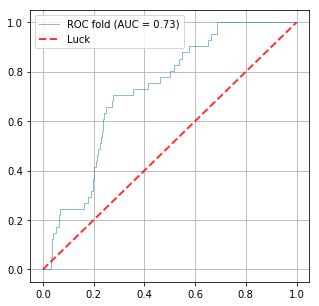

In [169]:
from sklearn.metrics import roc_curve, auc

def nn_iterations(train_data, train_targets, test_data, test_targets, iterations=100):
    
    true_pos_sum = []
    true_neg_sum = []
    fals_pos_sum = []
    fals_neg_sum = []
    sum_stats = []
    
    plt.figure(figsize=(5,5))
    
    for num in range(iterations):
        
        clf = MLPClassifier(solver='adam', alpha=.0001,
                            hidden_layer_sizes=(5,2),
                            max_iter=10000, verbose=False,
                            tol=.000001)
        clf.fit(train_data, train_targets)
        
        num_predict = len(test_data)

        predictions = clf.predict(test_data[:num_predict])
        predi_probs = clf.predict_proba(test_data[:num_predict])
        
        fpr, tpr, thresholds = roc_curve(test_targets, predi_probs[:, 1], drop_intermediate=True)
        roc_auc = auc(fpr, tpr)
        if roc_auc > .55:
            plt.plot(fpr, tpr, lw=1, alpha=0.5, label='ROC fold (AUC = %0.2f)' % (roc_auc))
        
        predi_fals = [x for x,y in predi_probs]
        predi_true = [y for x,y in predi_probs]
        
        for item in range(len(predictions)):
            
            if predictions[item] == test_targets[item]:
                pred = 'correct'
            else:
                pred = 'incorrect'
            
            sum_stats.append({str(num + 1): [test_targets[item], predictions[item], predi_probs[item][0], predi_probs[item][1], pred]})

        count_neg = len([x for x in test_targets if x == 0])
        count_pos = len([x for x in test_targets if x == 1])
        
        true_pos = []
        true_neg = []
        fals_pos = []
        fals_neg = []

        for sample in range(len(test_data)):
            if test_targets[sample] == 0:
                if predictions[sample] == test_targets[sample]:
                    true_neg.append(sample)
                else:
                    fals_neg.append(sample)
            elif test_targets[sample] == 1:
                if predictions[sample] == test_targets[sample]:
                    true_pos.append(sample)
                else:
                    fals_pos.append(sample)

        fals_pos_sum.append(str(len(fals_pos)/count_pos))
        fals_neg_sum.append(str(len(fals_neg)/count_neg))
        true_pos_sum.append(str(len(true_pos)/count_pos))
        true_neg_sum.append(str(len(true_neg)/count_neg))
        
        
        if roc_auc > .55:
            print(str(len(fals_pos)/count_pos), str(len(fals_neg)/count_neg), str(len(true_pos)/count_pos), str(len(true_neg)/count_neg))
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    fals_pos_sum = [float(x) for x in fals_pos_sum]
    fals_neg_sum = [float(x) for x in fals_neg_sum]
    true_pos_sum = [float(x) for x in true_pos_sum]
    true_neg_sum = [float(x) for x in true_neg_sum]
        
    fals_pos_sum = np.average(np.array(fals_pos_sum))
    fals_neg_sum = np.average(np.array(fals_neg_sum))
    true_pos_sum = np.average(np.array(true_pos_sum))
    true_neg_sum = np.average(np.array(true_neg_sum))

#     print('Summary statistics after ' + str(iterations) + ' iterations:')
#     print('True positive rate:  ' + str(np.round(true_pos_sum,3)))
#     print('False positive rate: ' + str(np.round(fals_pos_sum,3)))
#     print('True negative rate:  ' + str(np.round(true_neg_sum,3)))
#     print('False negative rate: ' + str(np.round(fals_neg_sum,3)))
    
    return predi_probs, sum_stats
    
predi_probs, sum_stats = nn_iterations(train_data, train_targets, test_data, test_targets, iterations=1)

In [163]:
for row in sum_stats[:50]:
    print(row)

{'1': [1, 1, 0.0015978923248050059, 0.99840210767519499, 'correct']}
{'1': [1, 1, 0.00022937999229144523, 0.99977062000770855, 'correct']}
{'1': [1, 1, 8.8687837422884996e-05, 0.99991131216257712, 'correct']}
{'1': [1, 1, 0.00018826453506592955, 0.99981173546493407, 'correct']}
{'1': [1, 1, 0.00015391809146791946, 0.99984608190853208, 'correct']}
{'1': [1, 1, 0.00022770047912712421, 0.99977229952087288, 'correct']}
{'1': [1, 1, 0.0040966500613023316, 0.99590334993869767, 'correct']}
{'1': [1, 1, 0.0036428556321441707, 0.99635714436785583, 'correct']}
{'1': [1, 1, 0.0012434181605687211, 0.99875658183943128, 'correct']}
{'1': [1, 1, 0.045721099506494278, 0.95427890049350572, 'correct']}
{'1': [1, 1, 0.096871151292472701, 0.9031288487075273, 'correct']}
{'1': [1, 1, 0.35664015709349584, 0.64335984290650416, 'correct']}
{'1': [1, 0, 0.66131734365348993, 0.33868265634651007, 'incorrect']}
{'1': [1, 1, 0.37857569826530724, 0.62142430173469276, 'correct']}
{'1': [1, 0, 0.55404610118513964, 0.